In [2]:
import os
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
# Dossiers
base_path = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented"

images_dir = os.path.join(base_path, "images")
masks_dir = os.path.join(base_path, "masks")

# Lister et trier tous les fichiers .jpg
image_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
mask_paths = sorted(glob(os.path.join(masks_dir, "*.jpg")))

print(f"Nombre d'images : {len(image_paths)}")
print(f"Nombre de masques : {len(mask_paths)}")

Nombre d'images : 5108
Nombre de masques : 5108


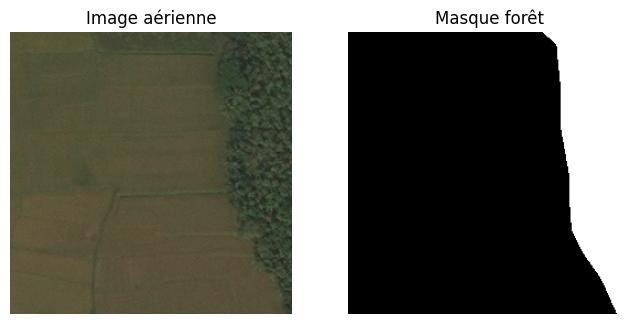

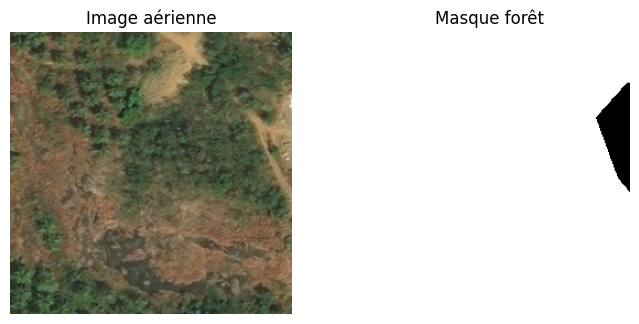

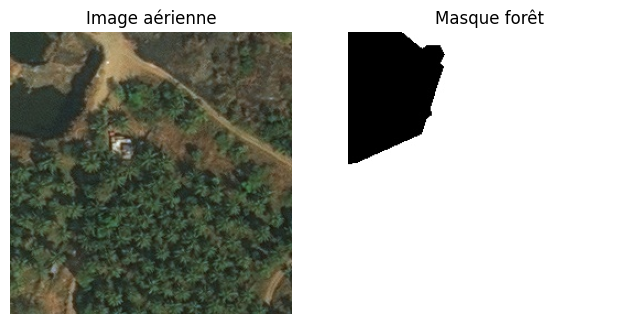

In [4]:
# Choisir 3 exemples aléatoires
for i in [0, 10, 20]:
    img = cv2.imread(image_paths[i])                 # Lire image (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convertir en RGB
    mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)  # Masque en niveaux de gris
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Image aérienne")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Masque forêt")
    plt.axis("off")
    
    plt.show()


In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = img / 255.0                         
    return img

def preprocess_mask(mask_path, threshold=127):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask > threshold, 1, 0)    
    mask = np.expand_dims(mask, axis=-1)      
    return mask

In [6]:

# 70% train
train_size = 0.7
# 20% val
val_size = 0.2 / (1 - train_size)  # proportion de la partie restante (30%)

# Split train / temp (train 70%, temp 30%)
train_img, temp_img, train_mask, temp_mask = train_test_split(
    image_paths, mask_paths, test_size=1-train_size, random_state=42
)

# Split temp en validation et test (20% et 10% du total)
val_img, test_img, val_mask, test_mask = train_test_split(
    temp_img, temp_mask, test_size=1-(val_size), random_state=42
)

print(f"Train: {len(train_img)} images")
print(f"Validation: {len(val_img)} images")
print(f"Test: {len(test_img)} images")

Train: 3575 images
Validation: 1021 images
Test: 512 images


In [7]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        # Nombre de batchs par epoch
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        # Créer un batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_img_paths = [self.image_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]
        
        # Préparer X et Y
        X = np.array([preprocess_image(p) for p in batch_img_paths], dtype=np.float32)
        Y = np.array([preprocess_mask(p) for p in batch_mask_paths], dtype=np.float32)
        return X, Y
    
    def on_epoch_end(self):
        # Mélange les indexes à chaque epoch si shuffle=True
        if self.shuffle:
            np.random.shuffle(self.indexes)

batch_size = 16

train_gen = DataGenerator(train_img, train_mask, batch_size=batch_size)
val_gen = DataGenerator(val_img, val_mask, batch_size=batch_size)
test_gen = DataGenerator(test_img, test_mask, batch_size=batch_size, shuffle=False)

In [8]:
X_batch, Y_batch = train_gen[0]
print("Shape X_batch :", X_batch.shape)
print("Shape Y_batch :", Y_batch.shape)

Shape X_batch : (16, 256, 256, 3)
Shape Y_batch : (16, 256, 256, 1)


In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape=(256,256,3)):
    inputs = Input(input_shape)
    
    # -------- Encoder (Downsampling) --------
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    # -------- Bottleneck --------
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(c4)
    
    # -------- Decoder (Upsampling) --------
    u5 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(64, (3,3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3,3), activation='relu', padding='same')(c5)
    
    u6 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(32, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(32, (3,3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(16, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(16, (3,3), activation='relu', padding='same')(c7)
    
    # -------- Output --------
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_unet(input_shape=(256,256,3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1760962896.490727      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760962896.491388      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      8,224 │ conv2d_9[0][0]  

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Paramètres
epochs = 30

# Entraînement du modèle
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1
)

Epoch 1/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 554ms/step - accuracy: 0.6484 - loss: 0.6334 - val_accuracy: 0.7062 - val_loss: 0.5906
Epoch 2/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - accuracy: 0.7211 - loss: 0.5739 - val_accuracy: 0.7195 - val_loss: 0.5732
Epoch 3/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.7383 - loss: 0.5528 - val_accuracy: 0.7234 - val_loss: 0.5658
Epoch 4/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.7521 - loss: 0.5335 - val_accuracy: 0.7558 - val_loss: 0.5223
Epoch 5/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - accuracy: 0.7572 - loss: 0.5195 - val_accuracy: 0.7638 - val_loss: 0.5120
Epoch 6/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.7774 - loss: 0.4925 - val_accuracy: 0.7783 - val_loss: 0.4972
Epoch 7/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.7795 - loss: 0.4918 - val_accuracy: 0.7716 - val_loss: 0.4988
Epoch 8/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.7886 - loss: 

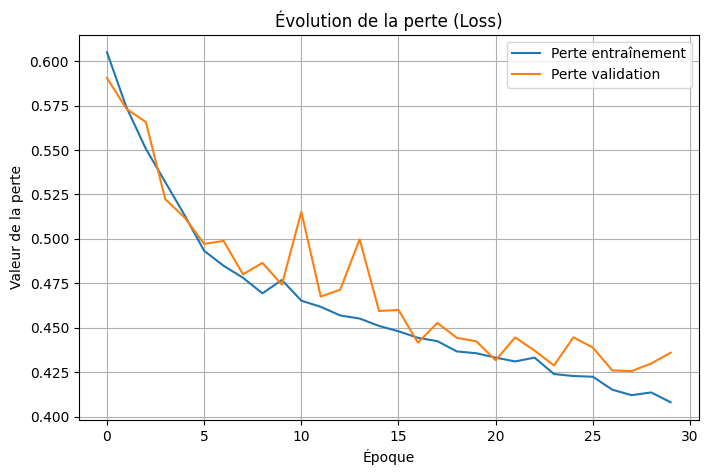

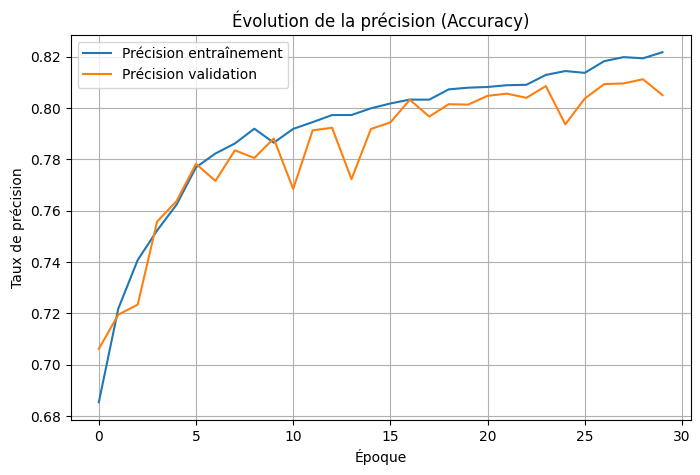

In [13]:
import matplotlib.pyplot as plt

# --- Courbes de perte (Loss) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Évolution de la perte (Loss)")
plt.xlabel("Époque")
plt.ylabel("Valeur de la perte")
plt.legend()
plt.grid(True)
plt.show()

# --- Courbes de précision (Accuracy) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title("Évolution de la précision (Accuracy)")
plt.xlabel("Époque")
plt.ylabel("Taux de précision")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


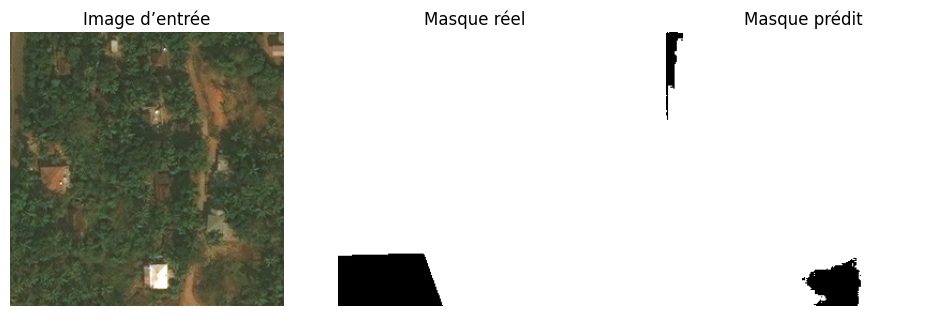

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


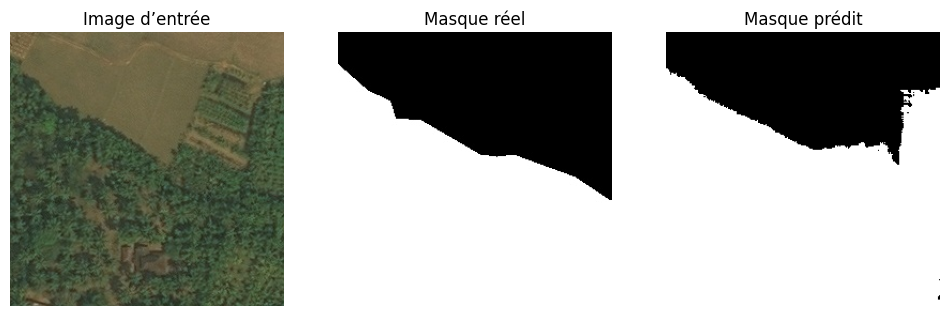

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


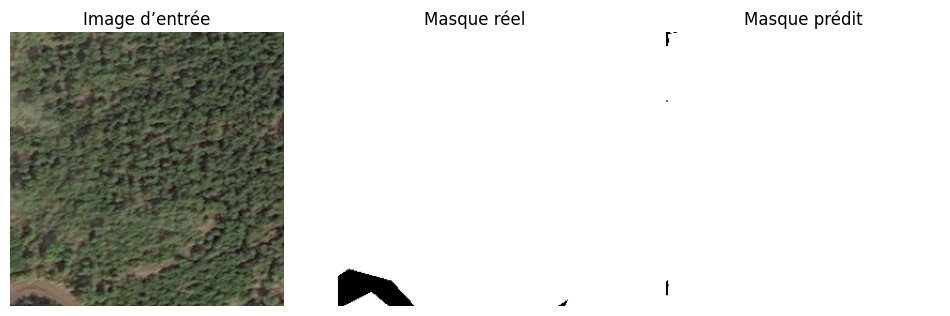

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Fonction pour prédire et afficher ---
def visualize_predictions(model, image_paths, mask_paths, num_samples=3):
    """
    Affiche quelques images avec leur masque réel et le masque prédit par le modèle.
    """
    for i in range(num_samples):
        # Sélectionner une image et son masque
        img_path = image_paths[i]
        mask_path = mask_paths[i]

        # Charger et prétraiter l’image
        img = np.array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = np.array(load_img(mask_path, target_size=(256, 256), color_mode="grayscale")) / 255.0

        # Ajouter une dimension batch pour la prédiction
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Seuil pour convertir en masque binaire (0 ou 1)
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Affichage côte à côte
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image d’entrée")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")

        plt.show()

# --- Utilisation avec ton dataset de test ---
visualize_predictions(model, test_img, test_mask, num_samples=3)


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

# ==========================
# 🔹 Fonctions de métriques
# ==========================
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# ==========================
# 🔹 Évaluation sur le test set
# ==========================
# Récupération du premier batch test
X_test, Y_test = test_gen[0]
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred > 0.5).astype(np.float32)

# ==========================
# 🔹 Calcul des métriques
# ==========================
iou = iou_metric(Y_test, Y_pred_bin)
dice = dice_coef(Y_test, Y_pred_bin)
precision = precision_score(Y_test.flatten(), Y_pred_bin.flatten())
recall = recall_score(Y_test.flatten(), Y_pred_bin.flatten())

# Évaluation pour récupérer la loss
eval_result = model.evaluate(X_test, Y_test, verbose=0)
loss_value = eval_result[0]  # index 0 = loss

# ==========================
# 🔹 Affichage des résultats
# ==========================
print(f"IoU (Intersection over Union): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Loss: {loss_value:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
IoU (Intersection over Union): 0.8114
Dice Coefficient: 0.8959
Precision: 0.8334
Recall: 0.9684
Loss: 0.3356
